# Fiscal Policy and Debt Management

In [1]:
using Calculus
using QuantEcon
import QuantEcon.simulate
using Calculus 
using Interpolations
using Plots
using BenchmarkTools

In [2]:
#Model parameters
β = 0.9
ψ = 1.00
#β = 0.8
α = 1.00
γ = 1.0
Π = [0.5 0.5;0.5 0.5]
μGrid = collect(linspace(-0.7,0.01,50))
G = [0.1;0.2]
P = [1.0;1.0]
nS = length(G)
A = eye(nS)
for s = 1:nS
    for sp = 1:nS
        if ~(s == sp)
            A[s,sp] = -β*Π[s,sp]
        else
            A[s,sp] = 1.-β*Π[s,sp]
        end
    end
end

parameters = (α,γ,β,ψ,Π,G,P,nS,A)

(1.0, 1.0, 0.9, 1.0, [0.5 0.5; 0.5 0.5], [0.1, 0.2], [1.0, 1.0], 2, [0.55 -0.45; -0.45 0.55])

## Lucas & Stokey economy

First we can solve the Lucas & stokey economy in order to get the complete markets solutions to be used as guesses. Note that we need guess

In [3]:
"""
Given the utility:
u = log(c) + ψ*log(n)

Solve the following system of equations

feasibility: c(s) + g(s) = l(s)
mris:        -un/uc = 1

inputs:
1. model parameters
2. convergence parameters (tol, maxit)

output:
1. c: consumption
2. n: labor
3. xi: lagrange multiplier of feasibility - marginal utility wrt consumption
"""
function find_FB(parameters,maxn=50, tol=1e-6)
    α,γ,β,ψ,Π,G,P,nS,A = parameters
            
    z = 0.3*ones(2*nS) #c and n
    xi = zeros(nS)
    res = zeros(2*nS)
    dres = zeros(2*nS,2*nS)
    for i = 1:100
        c = z[1:nS]
        n = z[nS+1:2*nS]
        for s = 1:nS
            uc   = c[s]^(-α)
            ucc  = -α*c[s]^(-1.-α)
            un   = -ψ*n[s]^γ
            unn  = -ψ*γ*n[s]^(γ-1.)
            #=uc = 1.0/c[s]
            un = -ψ/(1. -n[s])
            ucc = -c[s]^(-2)
            unn = -ψ/(1. -n[s])^2 
            uc = 1.0
            un = -ψ/(1. -n[s])
            ucc = 0.0
            unn = -ψ/(1. -n[s])^2=#
            
            ##residual
            res[s] = uc + un
            res[s+2] = n[s] - c[s] - G[s]
            
            ##jacobian
            dres[s,s] = ucc
            dres[s,s+nS] = unn
            dres[nS+s,s] = -1.
            dres[nS+s,nS+s] = 1.
        end
        step = -dres \ res
        z += step
        if norm(step)<tol
            break
        end
    end
    
    c = z[1:nS]
    n = z[nS+1:2*nS]
    
    for s =1:nS
        xi[s] = c[s]^(-α)
    end
    
    return [c;n;xi] 
end

find_FB

In [4]:
find_FB(parameters)

6-element Array{Float64,1}:
 0.951249
 0.904988
 1.05125 
 1.10499 
 1.05125 
 1.10499 

In [5]:
"""
Given the utility:
u = log(c) + ψ*log(n)

Household problem for t ≧ 1 for a household entering with "bonds" x at state s 

V(x,s) = max_{c,n,x'} u(c,1-n) + β∑π(s'|s)V(x',s')
s.t. 
x = uc(s)*c(s) - ul(s)*n(s) + β∑π(s'|s)x'(s')    :μ
c(s) + g(s) = n(s)                               :ξ(s)

This leads to finding the root of the following system

1. feasibility: c(s) + g(s) = n(s)
2. FOC wrt c:   uc - μ*(ucc(s)*c(s) + uc(s)) - ξ(s)
3. FOC wrt n:   un - μ*(unn(s)*n(s) + un(s)) + ξ(s)

inputs:
1. model parameters
2. convergence parameters (tol, maxit)

output:
1. c: consumption
2. n: labor
3. xi: lagrange multiplier of feasibility - marginal utility wrt consumption
"""
function time1_allocation(μ,parameters=parameters,maxn = 50, tol = 1e-6)
    α,γ,β,ψ,Π,G,P,nS,A = parameters
    
    z = find_FB(parameters)
    
    dres = zeros(3*nS,3*nS)
    res = zeros(3*nS)
    for i = 1:20
        c = z[1:nS]
        n = z[nS+1:2*nS]
        xi = z[2*nS+1:3*nS]
        for s = 1:nS
            uc   = c[s]^(-α)
            ucc  = -α*c[s]^(-1.-α)
            uccc = -α*(-α-1.)*c[s]^(-α-1.-1.)
            un   = -ψ*n[s]^(γ)
            unn  = -ψ*γ*n[s]^(γ-1)
            unnn = -ψ*γ*(γ-1.)*n[s]^(γ-1.-1.) 
            #=uc = 1.0/c[s]
            un = -ψ/(1. -n[s])
            ucc = -c[s]^(-2)
            uccc = 2.*c[s]^(-3)
            unn = -ψ/(1. -n[s])^2
            unnn = -2.*ψ/(1. -n[s])^3
            uc = 1.0
            un = -ψ/(1. -n[s])
            ucc = 0.0
            uccc = 0.0
            unn = -ψ/(1. -n[s])^2
            unnn = -2.*ψ/(1. -n[s])^3=#
            
            ##Residual
            res[s] = uc - μ*(ucc*c[s] + uc) - xi[s]
            res[nS+s] = un - μ*(unn*n[s] + un) + xi[s]
            res[2*nS+s] = n[s] - c[s] - G[s]
            
            ##Jacobian
            #first equations
            dres[s,s] = ucc - μ*(uccc*c[s] + ucc + ucc)
            dres[s,nS+s] = 0.0
            dres[s,2*nS+s] = -1.0
            #second equations
            dres[nS+s,s] = 0.0 
            dres[nS+s,nS+s] = unn - μ*(unnn*n[s] + unn + unn)
            dres[nS+s,2*nS+s] = 1.0
            #third equations
            dres[2*nS+s,s] = -1.0
            dres[2*nS+s,nS+s] = 1.0
            dres[2*nS+s,2*nS+s] = 0.0
        end
        step = -dres \ res
        z +=  step
        residual = norm(step)
        #println("residual at iteration ",i,": ",residual)
        if residual<tol
            break
        end
    end
        
    c = z[1:nS]
    n = z[nS+1:2*nS]
    xi = z[2*nS+1:3*nS]
    
    uc  = c.^(-α)
    un = -ψ*n.^(γ)
    LHS = uc.*c + un.*n
    x = A \ LHS
    
    
    return c,n,x,xi
end                    

time1_allocation

In [6]:
function time0_allocation(b_,s0,parameters=parameters,maxn = 5000, tol = 1e-5)
    β,ψ,Π,G,θ,nS,A = parameters
    
    #Get FB
    FB = find_FB(parameters)
    c_FB = FB[1:nS]
    n_FB = FB[nS+1:2*nS]
    xi_FB = FB[2*nS+1:3*nS]
    
    #Initial guess from FB
    z = [0.0;c_FB[1];n_FB[1];xi_FB[1]]
    
    dres = zeros(4,4)
    res = zeros(4)
    for i = 1:maxn
        μ,c0,n0,xi0 = z[1],z[2],z[3],z[4]
        xp = time1_allocation(μ)[3]
        uc0 = 1.0/c0
        un0 = -ψ/(1.0 - n0)
        ucc0 = -c0^(-2.)
        uccc0 = 2.0*c0^(-3.)
        unn0 = -ψ/(1.0 - n0)^2.
        unnn0 = -2.*ψ/(1.0 - n0)^3.

        ##Residual
        res[1] = uc0*(c0-b_) + un0*n0 + β*dot(Π[s0,:],xp)
        res[2] = uc0 - μ*(ucc0*(c0-b_) + uc0) - xi0
        res[3] = un0 - μ*(unn0*n0 + un0) + xi0
        res[4] = n0 - c0 - G[s0]

        ##Jacobian
        #first equation
        dres[1,1],dres[1,2] = 0.0, ucc0*(c0-b_) + uc0
        dres[1,3],dres[1,4] = unn0*n0 + un0, 0.0  
        #second equation       
        dres[2,1],dres[2,2] = -(ucc0*(c0-b_) + uc0), ucc0 - μ*(uccc0*(c0-b_) + ucc0 + ucc0)  
        dres[2,3],dres[2,4] = 0.0, -1.0
        #third equation       
        dres[3,1],dres[3,2] = -(unn0*n0 + un0), 0.0
        dres[3,3],dres[3,4] = unn0 - μ*(unnn0*n0 + unn0 + unn0), 1.0
        #fourth equation        
        dres[4,1],dres[4,2] = 0.0, -1.0 
        dres[4,3],dres[4,4] = 1.0, 0.0  
        
        #newton step
        step = -dres \ res
        
        #update
        z  +=  1/100*step
        residual = norm(step)
        println(residual)
        if residual<tol
            println("Converged in ",i," steps")
            break
        end
    end
    
    z
end

time0_allocation (generic function with 4 methods)

In [7]:
#find_FB(parameters)
#time1_allocation(-0.1)
#time0_allocation(0.45,1)

## Incomplete market set up

Now we'll use as a guess (input into newton) the complete market outcome. We have guesses for the following variables:

$$c_{s\_}(\mu,s),l_{s\_}(\mu,s),\xi_{s\_}(\mu,s),x_{s\_}(\mu) $$

We only don't have guesses for $\mu'_{s\_}(\mu,s)$. Afterall, the complete markets setup only has one lagrange multiplier on the IC constraint. 

In [8]:
function guess(
        _μ::Float64,
        _s::Int64,
        μGrid::Array{Float64},
        parameters = parameters)
    
    α,γ,β,ψ,Π,G,P,nS,A = parameters
    
    μ = zeros(nS)
    c,n,xp,ξ = time1_allocation(_μ) ####guess from complete markets
    uc,ucc,uccc = zeros(nS),zeros(nS),zeros(nS)
    un,unn,unnn = zeros(nS),zeros(nS),zeros(nS)
    
    for s = 1:nS
        uc[s]   = c[s]^(-α)
        ucc[s]  = -α*c[s]^(-1.-α)
        uccc[s] = -α*(-α-1.)*c[s]^(-α-1.-1.)
        un[s]   = -ψ*n[s]^(γ)
        unn[s]  = -ψ*γ*n[s]^(γ-1.)
        unnn[s] = -ψ*γ*(γ-1.)*n[s]^(γ-1.-1.)
    end 
    #=for s = 1:nS
        uc[s] = 1.0/c[s]
        un[s] = -ψ/(1. -n[s])
        ucc[s] = -c[s]^(-2)
        uccc[s] = 2.*c[s]^(-3)
        unn[s] = -ψ/(1. -n[s])^2
        unnn[s] = -2.*ψ/(1. -n[s])^3
    end 
    for s = 1:nS
        uc[s] = 1.0
        un[s] = -ψ/(1. -n[s])
        ucc[s] = 0.0
        uccc[s] = 0.0
        unn[s] = -ψ/(1. -n[s])^2
        unnn[s] = -2.*ψ/(1. -n[s])^3
    end =#


    
    #Guess for the state variable Bs
    B_s = zeros(length(μGrid),nS)    
    for μi = 1:length(μGrid)
        _,_,xp_,_ = time1_allocation(μGrid[μi])
        for s = 1:nS 
            B_s[μi,s] = xp_[s]
        end
    end
    knots = (μGrid,)
    Bitp = interpolate(knots,B_s[:,_s], Gridded(Linear())) 

    #Pre-allocating expectations 
    βexp_uc = 0.0
    expx = 0.0
    for s = 1:nS
        βexp_uc += β*Π[_s,s]*uc[s]
        expx += Π[_s,s]*xp[s]
    end
    #x = expx
    x = xp[_s]
    #x = zeros(nS)
    #x = xp
    
    μ = _μ*ones(nS)
    #Π[s_,s]*μ[s]*uc[s]/βexp_uc
    for s = 1:nS
        #if s != _s
        #    μ[s] = βexp_uc*(_μ - Π[_s,_s]*μ[_s]*uc[_s]/βexp_uc)/(Π[_s,s]*uc[s])
        #end
        #@show x[s] = βexp_uc*(Bitp[μ[s]] + uc*c[s] + un*n[s] )/uc
        μ[s] = 0.95*_μ #(un[s] + ξ[s])/(unn[s]*n[s] + un[s]) 
    end
    #μtil = min.(μGrid[end],max.(μ,μGrid[1])) 
    #μtil = [0.4;0.4]
    z = [c;n;μ;ξ;x]
    
    
    B_s,z
end 

guess (generic function with 2 methods)

In [9]:
function IM_time1_system(
        z::Array{Float64},
        μ_::Float64,
        s_::Int64,
        μGrid::Array{Float64},
        Bguess::Array{Float64},
        parameters=parameters,maxn = 50, tol = 1e-6)
    
    α,γ,β,ψ,Π,G,P,nS,A = parameters
    c = z[1:nS]
    n = z[nS+1:2*nS]
    μ = z[2*nS+1:3*nS]
    #μ = min.(μGrid[end],max.(z[2*nS+1:3*nS] ,μGrid[1])) 
    ξ = z[3*nS+1:4*nS]
    x = z[4*nS+1]

    
    #A = ones(length(μGrid))*xp[s_]
    knots = (μGrid,)
    Bitp = interpolate(knots,Bguess[:,s_], Gridded(Linear())) 
    
    
    uc,ucc,uccc = zeros(nS),zeros(nS),zeros(nS)
    un,unn,unnn = zeros(nS),zeros(nS),zeros(nS)
    
    #=for s = 1:nS
        uc[s] = 1.0/c[s]
        un[s] = -ψ/(1. -n[s])
        ucc[s] = -c[s]^(-2)
        uccc[s] = 2.*c[s]^(-3)
        unn[s] = -ψ/(1. -n[s])^2
        unnn[s] = -2.*ψ/(1. -n[s])^3
    end 
    for s = 1:nS
        uc[s] = 1.0
        un[s] = -ψ/(1. -n[s])
        ucc[s] = 0.0
        uccc[s] = 0.0
        unn[s] = -ψ/(1. -n[s])^2
        unnn[s] = -2.*ψ/(1. -n[s])^3
    end =#
    for s = 1:nS
        uc[s]   = c[s]^(-α)
        ucc[s]  = -α*c[s]^(-1.-α)
        uccc[s] = -α*(-α-1.)*c[s]^(-α-1.-1.)
        un[s]   = -ψ*n[s]^(γ)
        unn[s]  = -ψ*γ*n[s]^(γ-1)
        unnn[s] = -ψ*γ*(γ-1.)*n[s]^(γ-1.-1.)
    end
    
    
    
    βexp_uc = 0.0
    for s = 1:nS
        βexp_uc += β*Π[s_,s]*uc[s]
    end

    res = zeros(4*nS+1)
    
    #First 4 sets of functions that depend on s, build residual and jacobian of residual
    for s = 1:nS
        ##Residual
        Bitp = interpolate(knots,Bguess[:,s], Gridded(Linear()))
        res[s] = n[s] - c[s] - G[s]
        res[nS+s] = Bitp[μ[s]] + uc[s]*c[s] + un[s]*n[s] - uc[s]*x/βexp_uc   
        res[2*nS+s] = uc[s] - μ[s]*(ucc[s]*c[s] + uc[s]) + (μ[s] - μ_)*ucc[s]*x/βexp_uc - ξ[s]
        res[3*nS+s] = un[s] - μ[s]*(unn[s]*n[s] + un[s]) + ξ[s]
    end

    
    #last equation which does not depend on s
    rhs = 0.0
    for s = 1:nS
        rhs += β*Π[s_,s]*μ[s]*uc[s]/βexp_uc
    end
    res[4*nS+1] = μ_ - rhs
                
    res,z
end                  

IM_time1_system (generic function with 4 methods)

In [10]:
#BB,_z = guess(-0.5,1,μGrid)
BBst,zst = guess(-0.5,1,μGrid)
IM_time1_system(zst,-0.5,1,μGrid,BBst)[1]
#function system!(dx,x::Vector,check=Val{false}()) 
#    return IM_time1_system(x,-0.5,1,μGrid,BB)[1]
#end

9-element Array{Float64,1}:
 -2.77556e-17
  5.55112e-17
  0.00517043 
 -0.470204   
 -0.156607   
 -0.18025    
  0.0379436  
  0.0407071  
 -0.025      

In [11]:
function iteration_B(
        μGrid::Array{Float64},
        parameters = parameters)
    
    α,γ,β,ψ,Π,G,P,nS,A = parameters
    nμ = length(μGrid)
    
    #Initialize jacobian matrix
    num_der = zeros(4*nS+1,4*nS+1)
    c_pol = zeros(nS,nS,nμ) #s_,s,μ dimension
    n_pol = zeros(nS,nS,nμ) #s_,s,μ dimension
    μ_pol = zeros(nS,nS,nμ) #s_,s,μ dimension
    ξ_pol = zeros(nS,nS,nμ) #s_,s,μ dimension
    B_pol = zeros(nS,nS,nμ) #s_,s,μ dimension
    
    
    #Guess initial bond holdings 
    B_,z_ = guess(0.0,1,μGrid)
    
    #Initialize update for initial bond holdings
    #Bp = copy(B_)
    for n = 1:300
        #Bp = 0.0
        Bp = copy(B_)
        for si = 1:nS
            for μi = 1:nμ
                #initial multiplier
                μ_ = μGrid[μi]

                #Take a guess from the complete markets case
                _,z_ = guess(μ_,si,μGrid)


                #Start Newton's algorithm

                for ite = 1:50
                    #compute jacobian
                    for i = 1:4*nS+1
                         num_der[i,:] = Calculus.gradient(t -> IM_time1_system(t,μ_,si,μGrid,B_)[1][i],z_)
                    end
                    #num_der = ForwardDiff.jacobian(system!,num_der,z_)
                    
                    step = -num_der \ IM_time1_system(z_,μ_,si,μGrid,B_)[1]
                    #@show num_der
                    #@show μ_
                    z_ += step
                    #@show μi
                    #@show norm(step)
                    if norm(step) < 1e-10
                        println("converged")
                        Bp[μi,si] = z_[4*nS+1]
                        c_pol[si,:,μi] = z_[1:nS] #s_,s,μ
                        n_pol[si,:,μi] = z_[nS+1:2*nS] #s_,s,μ
                        μ_pol[si,:,μi] = z_[2*nS+1:3*nS] #s_,s,μ
                        ξ_pol[si,:,μi] = z_[3*nS+1:4*nS] #s_,s,μ
                        B_pol[si,:,μi] = z_[4*nS+1] #s_,s,μ     
                        break
                    end
                end
            end
        end
        @show norm(Bp - B_)
        if norm(Bp - B_) < 1e-5
            println("converged")
            return Bp,c_pol,n_pol,μ_pol,ξ_pol,B_pol
            break
        end
        B_ = Bp
    end
end

iteration_B (generic function with 2 methods)

In [12]:
BBp_pol,cc_pol,nn_pol,μμ_pol,ξξ_pol,BB_pol = iteration_B(μGrid)

converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged


([4.25337 4.25337; 4.19907 4.19907; … ; -1.38791 -1.38791; -1.6668 -1.6668], [0.57385 0.575082; 0.57385 0.575082]

[0.577831 0.578908; 0.577831 0.578908]

[0.58194 0.58276; 0.58194 0.58276]

...

[0.934545 0.884964; 0.934545 0.884964]

[0.948131 0.89926; 0.948131 0.89926]

[0.962316 0.914192; 0.962316 0.914192], [0.67385 0.775082; 0.67385 0.775082]

[0.677831 0.778908; 0.677831 0.778908]

[0.68194 0.78276; 0.68194 0.78276]

...

[1.03454 1.08496; 1.03454 1.08496]

[1.04813 1.09926; 1.04813 1.09926]

[1.06232 1.11419; 1.06232 1.11419], [-0.681821 -0.718218; -0.681821 -0.718218]

[-0.667156 -0.703899; -0.667156 -0.703899]

[-0.65252 -0.689547; -0.65252 -0.689547]

...

[-0.0178586 -0.0200412; -0.0178586 -0.0200412]

[-0.00371894 -0.00522092; -0.00371894 -0.00522092]

[0.0104774 0.00954643; 0.0104774 0.00954643], [1.59274 1.88844; 1.59274 1.88844]

[1.58227 1.87545; 1.58227 1.87545]

[1.5719 1.86226; 1.5719 1.86226]

...

[1.0715 1.12845; 1.0715 1.12845]

[1.05593 1.11074; 1.05593 1.11074

In [29]:
function time_series(
        μ0::Float64,
        s0::Int64,
        #T::Int64,
        state_series::Array{Int64},
        c_policy::Array{Float64} = cc_pol,
        l_policy::Array{Float64} = nn_pol,
        ξ_policy::Array{Float64} = ξξ_pol,
        μ_policy::Array{Float64} = μμ_pol,
        B_policy::Array{Float64} = BBp_pol,
        μ_Grid::Array{Float64} = μGrid,
        parameters=parameters)
    
    #BBp_pol,cc_pol,nn_pol,μμ_pol,ξξ_pol,BB_pol = iteration_B(μGrid)
    # Inputs
    #   - state_series     : times series of state indicators
    #   - μ0               : initial multiplier, μ_
    #   - s0               : initial state, s_
    #   - T                : number of time periods

    α,γ,β,ψ,Π,G,P,nS,A = parameters
    T = length(state_series)
    Grid = μ_Grid
    nμ = length(Grid)
    
    knots = (Grid,)
    #@show Citp = interpolate(knots,c_policy[1,1,:], Gridded(Linear())) 
    #@show 0.0
    
    # (B) - Initializations 
    C = zeros(T)                  # Consumption
    L = zeros(T)                  # Labor
    Bondsp = zeros(T)             # Bonds
    Tax = zeros(T)                # Tax rate
    LTR = zeros(T)                # Labor tax revenue
    gexp = zeros(T)               # Government Spending
    μ_state = zeros(T)            # μ_policy
    
    # (C) - Construct time series for variables 
    for t = 1:T
        
        # Select current state μ_
        if t==1
            μ_ = μ0
            #@show iμ_ = searchsortedlast(Grid,μ_) 
        else
            μ_ = μ_state[t-1] 
            #@show iμ_ = searchsortedlast(Grid,μ_) 
        end
        
        # Select past exogenous state s_
        if t==1
            s_ = s0
            #s_ = convert(Int64, s_)
        else
            s_ = state_series[t-1]
            #s_ = convert(Int64, s_)
        end
        
        # Select current state + exogenous variables
        s = state_series[t]
        Citp = interpolate(knots,c_policy[s_,s,:], Gridded(Linear())) 
        Litp = interpolate(knots,l_policy[s_,s,:], Gridded(Linear())) 
        μitp = interpolate(knots,μ_policy[s_,s,:], Gridded(Linear())) 
        Bitp = interpolate(knots,B_policy[:,s], Gridded(Linear())) 
        #s = convert(Int64, s)
        g = G[s]
        #p = S[s,1]
        
        # ---------
        # POLICIES
        # ---------
        
        # (1) - CONSUMPTION
        #@show c = c_policy[s_,s,iμ_]
        c = Citp[μ_]
        C[t] = c
        
        # (2) - LABOR
        #@show l = l_policy[s_,s,iμ_]
        l = Litp[μ_]
        L[t] = l
        
        # (3) - TAX RATE
        uc,un = c^(-α) , -ψ*l^γ
        Tax[t] = 1.0 + un/uc
        
        
        
       
        # (4) - LABOR TAX REVENUE
        #LTR[t] = l*τ
        
        # (5) - μ' POLICY given {s,μ_,s_}
        #μ = μ_policy[s_,s,iμ_]
        μ = μitp[μ_]  
        #@show iμ = searchsortedlast(Grid,μ) 
        μ_state[t] = μ
        
        #@show c+g
        #@show l
         
        
        # (6) - BONDS
        b = c*Bitp[μ]
        #b = c*B_policy[iμ,s]
        Bondsp[t] = b
        
        # (7) - GOVERNMENT SPENDING 
        gexp[t] = g 
        
    end
    
    # Stack all them up in a unique array
    
    #OUT = [C L Bondsp Tax gexp LTR μ_state]
    
    return C,L,Tax,μ_state,Bondsp,gexp
    
end

time_series (generic function with 9 methods)

In [30]:
mc = MarkovChain(Π, [1, 2])
sseries = simulate(mc,5000,init=1)
@time cc,ll,tt,μμ,bb,gg = time_series(-0.1,1,sseries,c_pol,n_pol,ξ_pol,μ_pol,Bp_pol,μGrid)

LoadError: [91mMethodError: no method matching interpolate(::Tuple{Array{Float64,3}}, ::Array{Float64,1}, ::Interpolations.Gridded{Interpolations.Linear})[0m
Closest candidates are:
  interpolate([91m::Tuple{Vararg{Union{AbstractArray{T,1}, Tuple} where T,N}}[39m, ::AbstractArray{Tel,N}, ::IT<:Union{Interpolations.Gridded, Interpolations.NoInterp, Tuple{Vararg{Union{Interpolations.Gridded, Interpolations.NoInterp},N} where N}}) where {Tel, N, IT<:Union{Interpolations.Gridded, Interpolations.NoInterp, Tuple{Vararg{Union{Interpolations.Gridded, Interpolations.NoInterp},N} where N}}} at /Users/joaorodrigues/.julia/v0.6/Interpolations/src/gridded/gridded.jl:57
  interpolate([91m::Type{TWeights}[39m, [91m::Type{TC}[39m, ::Any, [91m::IT<:Union{Interpolations.BSpline, Interpolations.NoInterp, Tuple{Vararg{Union{Interpolations.BSpline, Interpolations.NoInterp},N} where N}}[39m, [91m::GT<:Union{Interpolations.GridType, Interpolations.NoInterp, Tuple{Vararg{Union{Interpolations.GridType, Interpolations.NoInterp},N} where N}}[39m) where {TWeights, TC, IT<:Union{Interpolations.BSpline, Interpolations.NoInterp, Tuple{Vararg{Union{Interpolations.BSpline, Interpolations.NoInterp},N} where N}}, GT<:Union{Interpolations.GridType, Interpolations.NoInterp, Tuple{Vararg{Union{Interpolations.GridType, Interpolations.NoInterp},N} where N}}} at /Users/joaorodrigues/.julia/v0.6/Interpolations/src/b-splines/b-splines.jl:73[39m

In [17]:
tt

5000-element Array{Float64,1}:
  0.161386 
  0.155699 
  0.160361 
  0.165196 
  0.160226 
  0.164648 
  0.15965  
  0.164102 
  0.159076 
  0.153489 
  0.148106 
  0.142834 
  0.147826 
  ⋮        
 -0.0599869
 -0.0598208
 -0.0596515
 -0.0594789
 -0.0593031
 -0.0607024
 -0.0608812
 -0.0610563
 -0.0596787
 -0.0595067
 -0.0593314
 -0.0591528


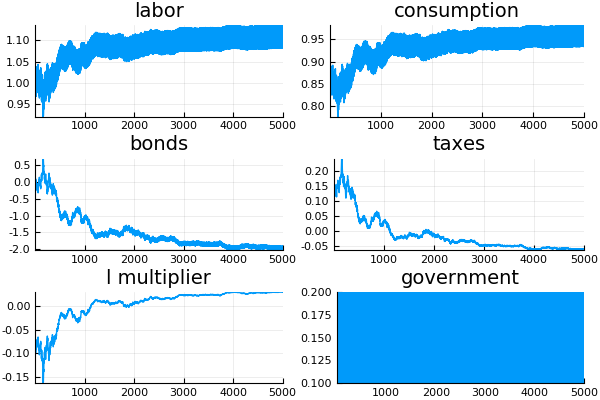

In [18]:
figl = plot(ll,title = "labor")
figc = plot(cc,title = "consumption")
figb = plot(bb,title = "bonds")
figt = plot(tt,title = "taxes")
figμ = plot(μμ,title = "l multiplier")
figg = plot(gg,title = "government")
plot(figl,figc,figb,figt,figμ,figg, layout=(3,2),legend = false)

In [ ]:
function IM_time1_allocation(
        μ_::Float64,
        s_::Int64,
        parameters=parameters,maxn = 50, tol = 1e-6)
    β,ψ,Π,G,θ,nS,A = parameters
    
    uc,ucc,uccc = zeros(nS),zeros(nS),zeros(nS)
    un,unn,unnn = zeros(nS),zeros(nS),zeros(nS)
    
    ##Generating a guess
    _μ = zeros(nS)
    _c,_n,_xp,_ξ = time1_allocation(μ_) ####guess from complete markets
    
    #Pre-allocating expectations 
    βexp_uc = 0.0
    expx = 0.0
    for s = 1:nS
        _uc = 1/_c[s]
        βexp_uc += β*Π[s_,s]*_uc
        expx += Π[s_,s]*_xp[s]
    end
    _x = expx
    
    for s = 1:nS
        _uc = 1.0/_c[s]
        _ucc = -_c[s]^(-2)
        _μ[s] = -0.05 #(_ξ[s] - _uc + μ_*_x*_ucc/βexp_uc)/(_ucc*_x/βexp_uc - _ucc*_c[s] - _uc)
    end
    z = [_c;_n;_μ;_ξ;_x]
    ########################################
    
    dres = zeros(4*nS+1,4*nS+1)
    res = zeros(4*nS+1)
    for i = 1:20
        c = z[1:nS]
        n = z[nS+1:2*nS]
        μ = z[2*nS+1:3*nS]
        ξ = z[3*nS+1:4*nS]
        x = z[4*nS+1]
        
        for s = 1:nS
            uc[s] = 1.0/c[s]
            un[s] = -ψ/(1. -n[s])
            ucc[s] = -c[s]^(-2)
            uccc[s] = 2.*c[s]^(-3)
            unn[s] = -ψ/(1. -n[s])^2
            unnn[s] = -2.*ψ/(1. -n[s])^3
        end
        
        #First 4 sets of functions that depend on s, build residual and jacobian of residual
        for s = 1:nS
            ##Residual
            res[s] = n[s] - c[s] - G[s]
            res[nS+s] = _xp[s] + uc[s]*c[s] + un[s]*n[s] - uc[s]*x/βexp_uc   
            res[2*nS+s] = uc[s] - μ[s]*(ucc[s]*c[s] + uc[s]) + ucc[s]*x/βexp_uc * (μ[s] - μ_) - ξ[s]
            res[3*nS+s] = un[s] - μ[s]*(unn[s]*n[s] + un[s]) + ξ[s]
            
            ##Jacobian
            #first equations
            dres[s,s] = -1.0
            dres[s,nS+s] = 1.0
            dres[s,2*nS+s] = 0.0
            dres[s,3*nS+s] = 0.0
            dres[s,4*nS+1] = 0.0
            
            #second equations
            for j = 1:nS
                (j==s)? dres[nS+s,j] = ucc[j]*c[j] + uc[j] - (ucc[j]*x*βexp_uc - 
                    uc[j]*x*β*Π[s_,j]*ucc[j])/βexp_uc^2.0:
                        dres[nS+s,j] = uc[s]*x*β*Π[s_,j]*ucc[j]/βexp_uc^2.0
            end
            dres[nS+s,nS+s] = unn[s]*n[s] + un[s]
            dres[nS+s,2*nS+s] = 0.0
            dres[nS+s,3*nS+s] = 0.0  
            dres[nS+s,4*nS+1] = -uc[s]/βexp_uc
            
            #third equations
            for j = 1:nS
                (j==s)? dres[2*nS+s,j] = ucc[j] - μ[j]*(uccc[j]*c[j] + ucc[j] + ucc[j]) + (uccc[j]*x*βexp_uc - 
                    β*Π[s_,j]*ucc[j]*ucc[j]*x)/βexp_uc^2 * (μ[j] - μ_) :
                        dres[2*nS+s,j] = -(μ[s] - μ_)*β*Π[s_,j]*ucc[j]*ucc[s]*x/βexp_uc^2
            end
            dres[2*nS+s,nS+s] = 0.0
            dres[2*nS+s,2*nS+s] = -1.0 * (ucc[s]*c[s] + uc[s]) + ucc[s]*x/βexp_uc 
            dres[2*nS+s,3*nS+s] = -1.0   
            dres[2*nS+s,4*nS+1] = ucc[s]/βexp_uc*(μ[s] - μ_)
            
            #fourth equations
            dres[3*nS+s,s] = 0.0
            dres[3*nS+s,nS+s] = unn[s] - μ[s]*(unnn[s]*n[s] + unn[s] + unn[s])
            dres[3*nS+s,2*nS+s] = -(unn[s]*n[s] + un[s])
            dres[3*nS+s,3*nS+s] = 1.0 
            dres[3*nS+s,4*nS+1] = 0.0
            
            #fifth equation
            dres[4*nS+1,s] = -(Π[s_,s]*μ[s]*ucc[s]*βexp_uc/βexp_uc^2 - 
                Π[s_,1]*μ[1]*uc[1]*β*Π[s_,s]*ucc[s]/βexp_uc^2 - Π[s_,2]*μ[2]*uc[2]*β*Π[s_,s]*ucc[s]/βexp_uc^2)
            dres[4*nS+1,nS+s] = 0.0
            dres[4*nS+1,2*nS+s] = -Π[s_,s]*uc[s]/βexp_uc            
            dres[4*nS+1,3*nS+s] = 0.0  
            #@show dres
        end
        #@show dres
        #@show res
                
        #last equation which does not depend on s
        rhs = 0.0
        for s = 1:nS
            rhs += Π[s_,s]*μ[s]*uc[s]/βexp_uc
        end
        res[4*nS+1] = μ_ - rhs
        dres[4*nS+1,4*nS+1] = 0.0
        
        #Newton update
        step = - dres \ res
        z +=  step
        residual = norm(step)
        println("residual at iteration ",i,": ",residual)
        if residual<tol
            break
        end
    end
        
#    c = z[1:nS]
#    n = z[nS+1:2*nS]
#    μ = z[2*nS+1:3*nS]
#    ξ = z[3*nS+1:4*nS]
#    x = z[4*nS+1]
        
#    return c,n,μ,ξ,x
    dres
end       